# Preparation of [WGI dataset](http://info.worldbank.org/governance/wgi/)

In [1]:
import numpy as np
import pandas as pd
from causal import ccm_bivariate, eval_candidate_DAGs, causal_discovery
from kernels import K_ID
from synthetic_data import spline_multi_sample
import pickle
import os
from tqdm.notebook import tqdm
import networkx as nx

Create a separate dataframe for each variable

In [2]:
df_VA = pd.read_excel(r'/home/felix/Dropbox/Research/projects/causal-fda/data/wgidataset.xlsx', sheet_name='VoiceandAccountability', header=13).rename(columns={'Unnamed: 0': 'Country'})
df_PS = pd.read_excel(r'/home/felix/Dropbox/Research/projects/causal-fda/data/wgidataset.xlsx', sheet_name='Political StabilityNoViolence', header=13).rename(columns={'Unnamed: 0': 'Country'})
df_GE = pd.read_excel(r'/home/felix/Dropbox/Research/projects/causal-fda/data/wgidataset.xlsx', sheet_name='GovernmentEffectiveness', header=13).rename(columns={'Unnamed: 0': 'Country'})
df_RQ = pd.read_excel(r'/home/felix/Dropbox/Research/projects/causal-fda/data/wgidataset.xlsx', sheet_name='RegulatoryQuality', header=13).rename(columns={'Unnamed: 0': 'Country'})
df_RL = pd.read_excel(r'/home/felix/Dropbox/Research/projects/causal-fda/data/wgidataset.xlsx', sheet_name='RuleofLaw', header=13).rename(columns={'Unnamed: 0': 'Country'})
df_CC = pd.read_excel(r'/home/felix/Dropbox/Research/projects/causal-fda/data/wgidataset.xlsx', sheet_name='ControlofCorruption', header=13).rename(columns={'Unnamed: 0': 'Country'})

In [3]:
dfs = [df_VA, df_PS, df_GE, df_RQ, df_RL, df_CC]

In [4]:
# check
df_GE

,Country,Unnamed: 1,1996,1996.1,1996.2,1996.3,1996.4,1996.5,1998,1998.1,...,2019.2,2019.3,2019.4,2019.5,2020,2020.1,2020.2,2020.3,2020.4,2020.5
0,Country/Territory,Code,Estimate,StdErr,NumSrc,Rank,Lower,Upper,Estimate,StdErr,...,NumSrc,Rank,Lower,Upper,Estimate,StdErr,NumSrc,Rank,Lower,Upper
1,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,80.28846,69.71154,92.78846,1.129532,0.35827,2,85.096153,71.153847,95.192307
2,Andorra,ADO,1.414038,0.187618,1,88.52459,83.60656,91.256828,1.46205,0.310279,...,1,98.07692,83.653847,100,1.825594,0.491762,1,96.634613,80.769234,100
3,Afghanistan,AFG,-2.175167,0.187618,1,0,0,1.639344,-2.135942,0.310279,...,8,7.211538,1.923077,13.461538,-1.523115,0.264619,7,5.288462,1.923077,12.5
4,Angola,AGO,-0.85994,0.173904,3,21.311476,12.021858,33.333332,-1.341783,0.203155,...,10,12.980769,7.211538,19.711538,-1.181797,0.202149,9,11.057693,5.288462,18.26923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,Serbia,SRB,-1.06468,0.173904,3,14.20765,6.010929,21.857924,-0.884606,0.228348,...,8,54.326923,39.423077,66.82692,0.032405,0.236001,7,54.326923,38.942307,67.78846
211,South Africa,ZAF,1.020496,0.168259,5,83.060112,75.409836,86.338799,0.657637,0.190554,...,13,66.82692,55.76923,74.03846,0.299396,0.18989,12,62.98077,53.365383,72.115387
212,"Congo, Dem. Rep.",ZAR,-1.649998,0.181661,2,3.825137,1.092896,6.010929,-1.878147,0.229129,...,10,4.807693,1.442308,10.096154,-1.692743,0.202149,9,3.365385,1.442308,9.134615
213,Zambia,ZMB,-1.128376,0.173904,3,12.568306,3.825137,21.311476,-0.869251,0.203155,...,11,27.403847,15.384615,38.942307,-0.767911,0.198649,11,22.115385,12.5,36.53846


Only work with Estimate and delete each Country that has NaNs in time-series:

In [5]:
for df in dfs:
    df.drop(columns=[c for c in df if c!='Country' and c not in list(np.arange(1996, 2021, 1))],inplace=True)
    df.drop(index=0, inplace=True)
    df.dropna(inplace=True)

Linearly interpolate missing years: 1997, 1999, 2001

In [6]:
columns = ['Country', 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

In [7]:
for df in dfs:
    for y in np.arange(1996, 2021, 1):
        if y not in df.columns:
            df[y] = np.nan
    
    df[np.arange(1996, 2021, 1)] = df[np.arange(1996, 2021, 1)].astype(float).interpolate(axis=1)

Reorder the columns:

In [8]:
df_VA = df_VA[columns]
df_PS = df_PS[columns]
df_GE = df_GE[columns]
df_RQ = df_RQ[columns]
df_RL = df_RL[columns]
df_CC = df_CC[columns]

Only work with countries where data are available for all six variables:

In [9]:
countries = set(df_VA['Country']) & set(df_PS['Country']) & set(df_GE['Country']) & set(df_RQ['Country']) & set(df_RL['Country']) & set(df_CC['Country'])

In [10]:
df_VA = df_VA.loc[df_VA['Country'].isin(countries)]
df_PS = df_PS.loc[df_PS['Country'].isin(countries)]
df_GE = df_GE.loc[df_GE['Country'].isin(countries)]
df_RQ = df_RQ.loc[df_RQ['Country'].isin(countries)]
df_RL = df_RL.loc[df_RL['Country'].isin(countries)]
df_CC = df_CC.loc[df_CC['Country'].isin(countries)]

In [11]:
# check
df_RQ

,Country,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
2,Andorra,1.266440,1.283571,1.300701,1.288353,1.276005,1.372423,1.468842,1.447286,1.424216,...,1.617491,1.568978,1.567499,0.885067,0.912940,0.871443,1.209727,1.193258,1.228282,1.339709
3,Afghanistan,-2.090330,-2.088793,-2.087256,-2.098441,-2.109626,-1.957038,-1.804449,-1.430002,-1.505863,...,-1.540586,-1.193118,-1.193137,-1.118182,-0.997371,-1.327688,-1.336691,-1.133277,-1.120690,-1.378587
4,Angola,-1.415345,-1.552502,-1.689659,-1.744495,-1.799331,-1.631245,-1.463160,-1.212144,-1.251539,...,-1.097776,-0.969778,-1.054224,-0.988459,-0.909186,-1.001380,-1.042228,-0.877683,-0.894037,-0.908502
6,Albania,-0.474402,-0.323725,-0.173049,-0.213704,-0.254359,-0.239527,-0.224694,-0.447581,-0.165745,...,0.232936,0.199169,0.209719,0.221990,0.186668,0.189022,0.223364,0.254197,0.273868,0.237131
8,United Arab Emirates,0.694305,0.658391,0.622476,0.675535,0.728593,0.924571,1.120548,0.671617,0.801586,...,0.449241,0.676252,0.780733,0.992054,1.111059,0.972596,1.015221,0.930290,0.979414,1.083404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,Serbia,-0.717160,-0.767131,-0.817102,-0.836724,-0.856347,-0.736899,-0.617452,-0.585421,-0.446547,...,0.025294,-0.063378,-0.061157,0.141216,0.155342,0.056300,0.009559,0.129221,0.132152,0.120264
211,South Africa,0.515014,0.421920,0.328826,0.382604,0.436383,0.546000,0.655617,0.804242,0.658264,...,0.406775,0.381753,0.419975,0.287686,0.279379,0.211844,0.233725,0.129722,0.156193,0.203909
212,"Congo, Dem. Rep.",-1.756227,-2.026881,-2.297536,-2.162491,-2.027446,-1.748212,-1.468978,-1.475788,-1.607705,...,-1.521802,-1.489312,-1.233635,-1.362629,-1.345490,-1.323978,-1.463433,-1.471100,-1.508590,-1.540846
213,Zambia,-0.482704,-0.295602,-0.108499,-0.183873,-0.259247,-0.429054,-0.598860,-0.551812,-0.543299,...,-0.438866,-0.426699,-0.474008,-0.503428,-0.436516,-0.483593,-0.465022,-0.483341,-0.553813,-0.619891


### Causal discovery on corruption and income inequality in Africa

In [12]:
Africa_countries = ['Algeria', 'Egypt, Arab Rep.', 'Morocco', 'Tunisia', 'Burundi', 'Comoros', 'Djibouti', 'Eritrea', 'Ethiopia', 'Kenya', 
'Madagascar', 'Malawi', 'Mauritius', 'Mozambique', 'Rwanda', 'Seychelles', 'Somalia', 'Uganda',
'Tanzania', 'Zambia', 'Zimbabwe', 'Angola', 'Cameroon', 'Central African Republic', 'Chad', 'Congo, Rep.',
'Congo, Dem. Rep.', 'Equatorial Guinea', 'Gabon', 'Botswana', 'Lesotho', 'Namibia',
'South Africa', 'Benin', 'Burkina Faso', "Côte d'Ivoire", 'Gambia, The', 'Ghana', 'Guinea-Bissau', 'Liberia',
'Mali', 'Mauritania', 'Niger', 'Nigeria', 'Senegal', 'Sierra Leone', 'Togo']

In [13]:
# corruption data
df_CC_Africa = df_CC[df_CC['Country'].isin(Africa_countries)].iloc[:, 0:22]

In [14]:
df_CC_Africa

,Country,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
4,Angola,-1.167702,-1.286769,-1.405836,-1.464261,-1.522685,-1.353157,-1.183629,-1.320665,-1.313559,...,-1.289693,-1.284621,-1.404655,-1.326095,-1.344277,-1.268470,-1.309463,-1.443944,-1.395014,-1.439528
16,Burundi,-0.680635,-0.729977,-0.779319,-0.791767,-0.804215,-0.813604,-0.822993,-0.895339,-0.892258,...,-1.160764,-1.090768,-1.129477,-1.165776,-1.187119,-1.452790,-1.409437,-1.258688,-1.257721,-1.245538
18,Benin,-0.548115,-0.545390,-0.542665,-0.508141,-0.473618,-0.600040,-0.726462,-0.478256,-0.464951,...,-0.463171,-0.503310,-0.615627,-0.660993,-0.593505,-0.856498,-0.743930,-0.666047,-0.550842,-0.513315
19,Burkina Faso,0.111519,0.004395,-0.102730,-0.086957,-0.071184,-0.031969,0.007246,-0.011932,-0.135678,...,-0.331875,-0.304823,-0.335337,-0.350699,-0.367833,-0.478925,-0.522940,-0.464794,-0.277289,-0.147976
34,Botswana,0.817961,0.853693,0.889424,0.860306,0.831187,0.743183,0.655179,1.216737,0.898180,...,1.003517,1.039068,0.959989,1.027206,0.995591,0.933343,0.923622,0.854549,0.852458,0.929928
35,Central African Republic,-1.140931,-1.073672,-1.006412,-1.091519,-1.176626,-1.134056,-1.091485,-1.160548,-1.385589,...,-1.189861,-1.115491,-0.976690,-0.929904,-0.946692,-0.992719,-1.090543,-1.160188,-1.308274,-1.279835
40,Côte d'Ivoire,-0.260567,-0.364913,-0.469259,-0.577060,-0.684861,-0.727029,-0.769197,-0.979914,-1.206059,...,-1.091263,-1.107821,-1.104134,-1.158213,-1.012885,-0.830353,-0.735374,-0.419105,-0.434921,-0.529941
41,Cameroon,-1.334985,-1.277612,-1.220239,-1.206318,-1.192397,-1.179798,-1.167200,-0.978817,-1.108283,...,-1.020625,-1.022167,-1.003626,-1.061337,-1.145436,-1.261209,-1.205025,-1.164030,-1.074647,-1.154283
42,"Congo, Rep.",-0.860740,-1.065736,-1.270732,-1.196290,-1.121848,-1.058211,-0.994574,-1.010288,-0.927982,...,-1.146641,-1.175675,-1.195680,-1.146949,-1.119156,-1.211168,-1.153706,-1.178814,-1.196223,-1.186817
45,Comoros,-0.998565,-1.112410,-1.226254,-1.166205,-1.106156,-1.001820,-0.897485,-0.855613,-0.899970,...,-0.706745,-0.790295,-0.828634,-0.807133,-0.790605,-0.783355,-0.739784,-0.612173,-0.719177,-0.665736


In [15]:
# income inequality data
df_IE = pd.read_csv(r'/home/felix/Dropbox/Research/projects/causal-fda/data/gini.csv')
df_IE.replace("Cote d'Ivoire", "Côte d'Ivoire", inplace=True)

df_IE_Africa = df_IE[df_IE['Country'].isin(Africa_countries)]
df_IE_Africa_time = df_IE_Africa.loc[:, df_IE_Africa.columns != 'Country']
df_IE_Africa_time_1 = df_IE_Africa_time.replace('..', np.nan).astype(float).interpolate(axis=1)
df_IE_Africa_time_2 = df_IE_Africa_time_1.fillna(df_IE_Africa_time_1.mean(axis=0))

df_IE_Africa_int = pd.concat([df_IE_Africa.loc[:, df_IE_Africa.columns=='Country'], df_IE_Africa_time_2], axis=1)

In [16]:
df_IE_Africa_int

,Country,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
4,Algeria,47.44,48.248452,45.693767,43.361004,43.838609,43.386895,43.661543,43.828650,44.120434,...,43.275027,43.462715,43.417346,43.365270,27.600000,27.600000,27.600000,27.600000,27.600000,27.600000
7,Angola,47.44,48.248452,45.693767,43.361004,52.000000,50.837500,49.675000,48.512500,47.350000,...,43.862500,42.700000,42.700000,42.700000,42.700000,42.700000,42.700000,42.700000,42.700000,42.700000
23,Benin,47.44,48.248452,45.693767,43.361004,43.838609,43.386895,43.661543,38.600000,39.200000,...,41.000000,41.600000,42.200000,42.800000,43.400000,44.500000,45.600000,46.700000,47.800000,47.800000
28,Botswana,47.44,48.248452,45.693767,43.361004,43.838609,43.386895,64.700000,64.100000,63.500000,...,61.700000,61.100000,60.500000,59.300000,58.100000,56.900000,55.700000,54.500000,53.300000,53.300000
33,Burkina Faso,47.44,48.248452,49.900000,48.580000,47.260000,45.940000,44.620000,43.300000,42.716667,...,40.966667,40.383333,39.800000,38.900000,38.000000,37.100000,36.200000,35.300000,35.300000,35.300000
34,Burundi,47.44,48.248452,42.300000,41.187500,40.075000,38.962500,37.850000,36.737500,35.625000,...,34.142857,34.885714,35.628571,36.371429,37.114286,37.857143,38.600000,38.600000,38.600000,38.600000
37,Cameroon,44.40,43.940000,43.480000,43.020000,42.560000,42.100000,42.216667,42.333333,42.450000,...,42.800000,43.342857,43.885714,44.428571,44.971429,45.514286,46.057143,46.600000,46.600000,46.600000
41,Central African Republic,47.44,48.248452,45.693767,43.361004,43.838609,43.386895,43.661543,43.828650,44.120434,...,43.275027,56.200000,56.200000,56.200000,56.200000,56.200000,56.200000,56.200000,56.200000,56.200000
43,Chad,47.44,48.248452,45.693767,43.361004,43.838609,43.386895,43.661543,39.800000,40.237500,...,41.550000,41.987500,42.425000,42.862500,43.300000,43.300000,43.300000,43.300000,43.300000,43.300000
48,Comoros,47.44,48.248452,45.693767,43.361004,43.838609,43.386895,43.661543,43.828650,55.900000,...,52.720000,51.660000,50.600000,49.540000,48.480000,47.420000,46.360000,45.300000,45.300000,45.300000


#### CCM analysis

In [17]:
DAGs = {}
DAGs_01 = {}
DAGs_10 = {}
p_values = {}
p_values_01 = {}
p_values_10 = {}
for i, country in enumerate(df_CC_Africa['Country']):
    arr1 = df_CC_Africa.loc[df_CC_Africa['Country']==country].loc[:, df_CC_Africa.columns != 'Country'].to_numpy()
    arr2 = df_IE_Africa_int.loc[df_IE_Africa_int['Country']==country].loc[:, df_IE_Africa_int.columns != 'Country'].to_numpy()
    arr = np.asarray([arr1, arr2]).squeeze()

    DAG, _, p_value, _ = ccm_bivariate(arr, alpha=0.05)
    DAGs[country] = DAG
    p_values[country] = p_value
    
    if DAG == {0: [], 1: 0}:
        DAGs_01[i] = DAG
        p_values_01[i] = p_value
        
    if DAG == {0: 1, 1: []}:
        DAGs_10[i] = DAG
        p_values_10[i] = p_value

In [18]:
len(DAGs_01)/len(DAGs)

0.7021276595744681

#### Regression-based analysis

In [19]:
np_CC_Africa = np.zeros(df_CC_Africa.iloc[:, 1:].shape)
np_IE_Africa = np.zeros(df_CC_Africa.iloc[:, 1:].shape)

for i, country in enumerate(df_CC_Africa['Country']):
    np_CC_Africa[i] = df_CC_Africa.loc[df_CC_Africa['Country']==country].loc[:, df_CC_Africa.columns != 'Country'].to_numpy()
    np_IE_Africa[i] = df_IE_Africa_int.loc[df_IE_Africa_int['Country']==country].loc[:, df_IE_Africa_int.columns != 'Country'].to_numpy()

In [20]:
arr = np.asarray([np_CC_Africa, np_IE_Africa]).squeeze()
n_intervals = 12
analyse = False
pred_points = np.linspace(0, 1, 21)
n_neighbours = 5
n_perms = 1000
alpha = 0.05
make_K = K_ID
regressor = 'hist'

print(eval_candidate_DAGs(arr, pred_points, n_intervals, n_neighbours, n_perms, alpha, 
                          make_K, analyse, regressor, pd_graph=None))

({0: [1], 1: []}, 0.08900000000000008)


### Causal discovery on the WGI dataset

Countries are seen as independent samples, data are taken from 1996 to 2020. Each country has one score for each variable in every year.

In [21]:
np_VA = df_VA.loc[:, df_VA.columns != 'Country'].to_numpy()
np_PS = df_PS.loc[:, df_PS.columns != 'Country'].to_numpy()
np_GE = df_GE.loc[:, df_GE.columns != 'Country'].to_numpy()
np_RQ = df_RQ.loc[:, df_RQ.columns != 'Country'].to_numpy()
np_RL = df_RL.loc[:, df_RL.columns != 'Country'].to_numpy()
np_CC = df_CC.loc[:, df_CC.columns != 'Country'].to_numpy()

In [22]:
n_vars = 6
n_samples, n_years = np_VA.shape
nps = np.zeros((n_vars, n_samples, n_years))
nps[0] = np_VA
nps[1] = np_PS
nps[2] = np_GE
nps[3] = np_RQ
nps[4] = np_RL
nps[5] = np_CC

In [23]:
# experiment parameters
cd_type = 'combined'
obs_points = np.tile(np.linspace(0, 1, nps.shape[2]), (n_samples, 1))
pred_points = np.linspace(0, 1, 100)
n_intervals = 12
n_neighbours = 3
n_perms = 1000
alpha = 0.05
make_K = K_ID
lambs = 1e-1
n_pretests = 100
n_steps = 50
analyse = True
regressor = 'hist'
init = 'cond_set'
find_lambda = False

l_cond = np.zeros(n_vars - 2)
r_opts = np.zeros(n_vars - 2)

In [24]:
# data preparation
nps_int = np.zeros((nps.shape[0], nps.shape[1], len(pred_points)))
for d in range(nps.shape[0]):
    nps_int[d] = spline_multi_sample(nps[d], obs_points, pred_points).evaluate(pred_points).squeeze()

In [26]:
%%time
sparse_g, _DAGs, p_values, lamb_cond, rejects_opts, lags, corr_values = causal_discovery(cd_type, nps_int, pred_points, n_intervals, n_neighbours, n_perms, alpha, make_K, lambs, n_pretests, 
                                                                                         n_steps, analyse, regressor, l_cond, r_opts, init, find_lambda, pd_graph)

Evaluating DAG #0: {0: [], 3: [0], 2: [], 4: [2], 5: [2, 4]}
Independence test p-value: nan
Evaluating DAG #1: {0: [], 3: [0], 2: [], 4: [2, 5], 5: [2]}
Independence test p-value: nan
Evaluating DAG #2: {0: [], 3: [0], 2: [5], 4: [2], 5: [4]}
Independence test p-value: nan
Evaluating DAG #3: {0: [], 3: [0], 2: [5], 4: [2, 5], 5: []}
Independence test p-value: nan
Evaluating DAG #4: {0: [], 3: [0], 2: [4], 4: [], 5: [2, 4]}
Independence test p-value: nan
Evaluating DAG #5: {0: [], 3: [0], 2: [4], 4: [5], 5: [2]}
Independence test p-value: nan
Evaluating DAG #6: {0: [], 3: [0], 2: [4, 5], 4: [], 5: [4]}
Independence test p-value: nan
Evaluating DAG #7: {0: [], 3: [0], 2: [4, 5], 4: [5], 5: []}
Independence test p-value: nan
Evaluating DAG #8: {0: [3], 3: [], 2: [], 4: [2], 5: [2, 4]}
Independence test p-value: nan
Evaluating DAG #9: {0: [3], 3: [], 2: [], 4: [2, 5], 5: [2]}
Independence test p-value: nan
Evaluating DAG #10: {0: [3], 3: [], 2: [5], 4: [2], 5: [4]}
Independence test p-valu

In [27]:
print(sparse_g, _DAGs, p_values, lamb_cond, rejects_opts, lags, corr_values)

[] {0: [], 3: [0], 2: [], 4: [2], 5: [2, 4]} nan 0 0 0 0


### Draw networks

#### Undirected network

In [54]:
for i in range(nps.shape[0]):
    if i not in list(_DAGs.keys()):
        _DAGs[i] = []

In [70]:
pg_graph = nx.Graph()

for d, p_list in _DAGs.items():
    pd_graph.add_node(d)
    for p in p_list:
        pd_graph.add_edge(p, d)
        
pg.add_nodes_from(sorted(pg_graph.nodes(data=True)))
pg.add_edges_from(pg_graph.edges(data=True))

In [71]:
# label variables according to official WGI names
mapping = {0: "VA", 1: "PS", 2: "GE", 3: "RQ", 4: "RL", 5: "CC"}
pg_ = nx.relabel_nodes(pg, mapping)

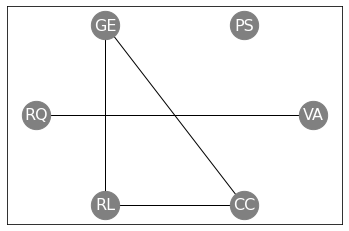

In [76]:
nx.draw_networkx(pg_, pos=nx.circular_layout(pg_), node_color='grey', node_size=800, font_color='white', font_size=16)

#### Directed network

In [78]:
g_graph = nx.DiGraph()

for d, p_list in _DAGs.items():
    g_graph.add_node(d)
    for p in p_list:
        g_graph.add_edge(p, d)

In [80]:
g = nx.DiGraph()
g.add_nodes_from(sorted(g_graph.nodes(data=True)))
g.add_edges_from(g_graph.edges(data=True))

In [81]:
mapping = {0: "VA", 1: "PS", 2: "GE", 3: "RQ", 4: "RL", 5: "CC"}
g_ = nx.relabel_nodes(g, mapping)

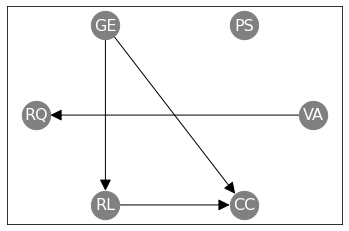

In [82]:
nx.draw_networkx(g_, pos=nx.circular_layout(g_), arrowsize=24, node_color='grey', node_size=800, font_color='white', font_size=16)

# Preparation of [SDG Index dataset](https://dashboards.sdgindex.org/downloads)

In [ ]:
df_SDG = pd.read_excel(r'/home/felix/Dropbox/Research/projects/causal-fda/data/sdgindexdataset.xlsx', sheet_name='Raw Data - Trend Indicators').drop(columns=['id', 'indexreg', 'Population'])

In [ ]:
indicators = df_SDG.drop(columns=['Country', 'Year']).columns.tolist()
no_countries = ['Upper-middle-income Countries', 'Western Balkans', 
                'Small Island Developing States', 'OECD members', 'Oceania',
                'Middle East and North Africa', 'Low-income Countries', 
                'Lower-middle-income Countries', 'Latin America and the Caribbean',
                'High-income Countries', 'East and South Asia', 
                'Eastern Europe and Central Asia', 'Sub-Saharan Africa']

countries = []
for country in list(pd.unique(df_SDG['Country'])):
    if country not in no_countries:
        countries.append(country)

years = pd.unique(df_SDG['Year']).tolist()

In [ ]:
# interpolate and save data in array
np_SDG_ind = np.zeros((len(indicators), len(countries), len(years)))

for i_ind, ind in tqdm(enumerate(indicators), total=len(indicators)):
    for i_c, country in enumerate(countries):
        
        if 1 < sum(df_SDG[df_SDG['Country']==country][ind].isna() == False) <= 2:
            m = 'spline'
            o = 1
        elif sum(df_SDG[df_SDG['Country']==country][ind].isna() == False) <= 1:
            m = 'linear'
            o = 2
        else:
            m = 'spline'
            o = 2
        
        s = df_SDG[df_SDG['Country']==country][ind].interpolate(method=m, order=o, limit_direction='both', limit=len(df_SDG[df_SDG['Country']==country][ind])).tolist()
        np_SDG_ind[i_ind, i_c] = s

In [ ]:
# compare
df_SDG[df_SDG['Country']=='Albania']['sdg1_wpc']

In [ ]:
# compare
np_SDG_ind[0][1]

In [ ]:
# define the indicators that belong to the same SDG
dict_indicators = {}

for goal in np.arange(1, 18):
    dict_indicators[goal] = []
    for ind in indicators:
        if ind.startswith(('sdg' + str(goal) + '_')):
            dict_indicators[goal].append(ind)

In [ ]:
dict_indicators

In [ ]:
# concatenate indicator data that belong to the same SDG, resulting in shape (17, n_countries, n_years*n_indicators), 
# deleting indicators that do not have any data available
dict_goals = {}

for goal in np.arange(1, 18):
    dict_goals[goal] = {}
    for i_c, country in enumerate(countries):
        dict_goals[goal][country] = []
        for i_ind, ind in enumerate(dict_indicators[goal]):
            if np.isnan(np_SDG_ind[i_ind, i_c]).all():
                pass
            else:
                dict_goals[goal][country].extend(list(np_SDG_ind[i_ind, i_c]))   

In [ ]:
# finding countries that do not have any data for one of the indicators
countries_to_del = []
for i_c, country in enumerate(countries):
    for goal in np.arange(1, 18):
        if len(dict_goals[goal][country]) == 0:
            countries_to_del.append(country)

countries_to_del = list(np.unique(countries_to_del))

In [ ]:
# deleting those countries that do not have any data for one of the indicators
for country in countries_to_del:
    for goal in np.arange(1, 18):
        dict_goals[goal].pop(country)

In [ ]:
# checking the number of countries for each goal
for goal in np.arange(1, 18):
    print(len(dict_goals[goal].keys()))
    
countries_left = list(dict_goals[goal].keys())

In [ ]:
lengths = {}
for goal in np.arange(1, 18):
    for i_c, country in enumerate(countries_left):
        if i_c == 0:
            lengths[goal] = len(dict_goals[goal][country])
            print('----------')
            print('Length of SDG {} in {}:'.format(goal, country), lengths[goal])
        
        if len(dict_goals[goal][country]) != lengths[goal]:
            print(country, len(dict_goals[goal][country]))

In [ ]:
# experiment parameters
cd_type = 'constraint'
pred_points = np.linspace(0, 1, 100)
n_intervals = 12
n_neighbours = 3
n_perms = 1000
alpha = 0.05
make_K = K_ID
lambs = 1e-1
n_pretests = 100
n_steps = 50
analyse = True
regressor = 'hist'

l_cond = np.zeros(n_vars - 2)
r_opts = np.zeros(n_vars - 2)

In [ ]:
causal_discovery(cd_type, nps, pred_points, n_intervals, n_neighbours, n_perms, alpha, make_K, lambs, n_pretests, 
                 n_steps, analyse, regressor, l_cond, r_opts)